In [1]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle
import os
import pandas as pd

from spec_utils import read_irs

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


### read in all the spectra of disks with water detections

In [2]:
path = os.getcwd() + '/REDUCED/'
gwlup=read_irs('GWLUP',dd=path,noerror=True)
imlup=read_irs('IMLUP',dd=path,noerror=True)
rulup=read_irs('RULUP',dd=path,noerror=True)
doar25=read_irs('DOAR25',dd=path,noerror=True)
waoph6=read_irs('WAOPH6',dd=path,noerror=True)
fztau=read_irs('FZTAU',dd=path,noerror=True)
twcha=read_irs('TWCHA',dd=path,noerror=True)
vzcha=read_irs('VZCHA',dd=path,noerror=True)
gqlup=read_irs('GQLUP',dd=path,noerror=True)
gktau=read_irs('GKTAU',dd=path,noerror=True)
citau=read_irs('CITAU',dd=path,noerror=True)
rylup=read_irs('RYLUP',dd=path,noerror=True)
iqtau=read_irs('IQTAU',dd=path,noerror=True)
as205=read_irs('AS205_c2d',dd=path,noerror=True)
iras=read_irs('04385+2550',dd=path,noerror=True)
as209=read_irs('V1121OPH',dd=path,noerror=True)

In [3]:
gwlup_f=interp1d(gwlup.wave,gwlup.flux)
imlup_f=interp1d(imlup.wave,imlup.flux)
rulup_f=interp1d(rulup.wave, rulup.flux)
doar25_f=interp1d(doar25.wave, doar25.flux)
waoph6_f=interp1d(waoph6.wave, waoph6.flux)
fztau_f=interp1d(fztau.wave, fztau.flux)
twcha_f=interp1d(twcha.wave, twcha.flux)
vzcha_f=interp1d(vzcha.wave, vzcha.flux)
gqlup_f=interp1d(gqlup.wave, gqlup.flux)
gktau_f=interp1d(gktau.wave, gktau.flux)
citau_f=interp1d(citau.wave, citau.flux)
rylup_f=interp1d(rylup.wave, rylup.flux)
iqtau_f=interp1d(iqtau.wave, iqtau.flux)
as205_f=interp1d(as205.wave,as205.flux)
iras_f=interp1d(iras.wave,iras.flux)
as209_f=interp1d(as209.wave,as209.flux)

### read in H2O model and H218O model

In [4]:
# H2O model
out_h2o=pickle.load(open('models/h2o_1e22_500_1au2_1pc_irs.p','rb'))

Text(0, 0.5, 'Flux (Jy)')

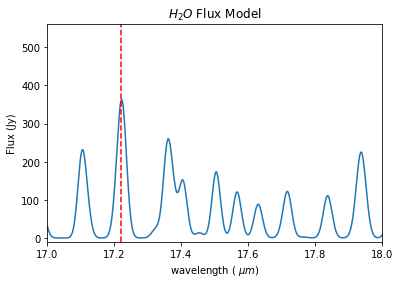

In [5]:
plt.plot(out_h2o['spectrum']['wave'],out_h2o['spectrum']['convolflux'])
plt.axvline(x=17.22, color='r', ls='--')
plt.xlim(17, 18)
plt.ylim(-10, 560)
plt.title("$H_2 O$ Flux Model")
plt.xlabel('wavelength ( $\mu m$)')
plt.ylabel('Flux (Jy)')

In [6]:
# read in H218O model
out_h218o=pickle.load(open('models/h218o_1e22_500_1au2_1pc_irs.p','rb'))

Text(0, 0.5, 'Flux (Jy)')

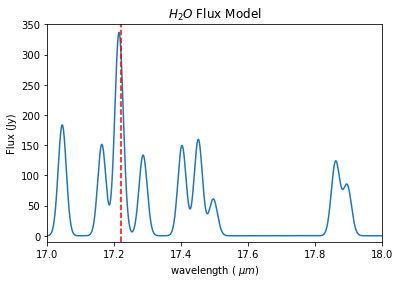

In [7]:
plt.plot(out_h218o['spectrum']['wave'],out_h218o['spectrum']['convolflux'])
plt.axvline(x=17.22, color='r', ls='--')
plt.xlim(17, 18)
plt.ylim(-10, 350)
plt.title("$H_2 O$ Flux Model")
plt.xlabel('wavelength ( $\mu m$)')
plt.ylabel('Flux (Jy)')

### combine spectra of all disks with water detections and plot models on top

In [30]:
xvals = np.linspace(14, 19, 500)
add = (gwlup_f(xvals)+imlup_f(xvals)+rulup_f(xvals)+doar25_f(xvals)+waoph6_f(xvals)+fztau_f(xvals)+twcha_f(xvals)
+vzcha_f(xvals)+gqlup_f(xvals)+gktau_f(xvals)+citau_f(xvals)+rylup_f(xvals)+iqtau_f(xvals)+as205_f(xvals)
+iras_f(xvals)+as209_f(xvals))

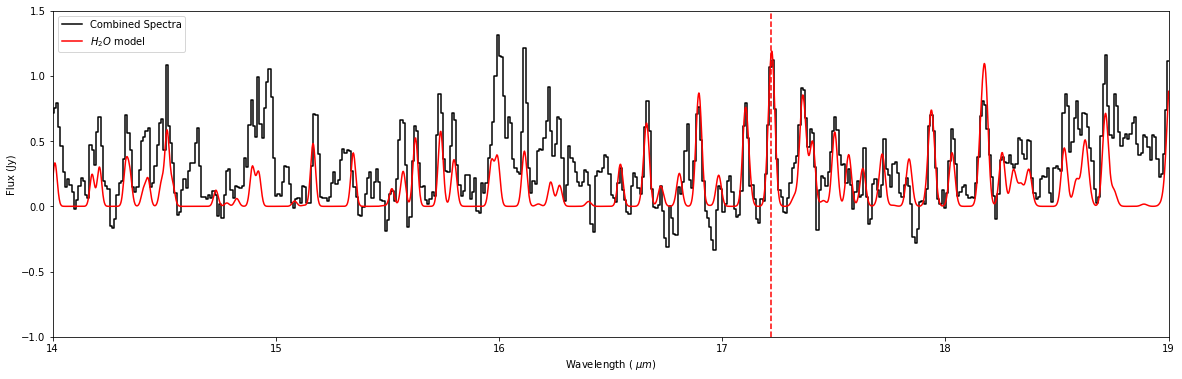

In [31]:
plt.figure(figsize = (20, 6))
plt.plot(xvals, add, color='black', drawstyle='steps-mid', label='Combined Spectra')

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 305
plt.plot(xh2o,yh2o, color='r', label='$H_2O$ model')
plt.axvline(x=17.22, color='r', ls='--')

plt.xlim(14, 19)
plt.ylim(-1, 1.5)

plt.xlabel('Wavelength ( $\mu m$)')
plt.ylabel('Flux (Jy)')
plt.legend(loc="upper left")


In [99]:
h2o_f=interp1d(out_h2o['spectrum']['wave'].data,out_h2o['spectrum']['convolflux'].data / 305)
h2o_model = h2o_f(xvals)

In [104]:
subtracted = []
for i in range(500):
    item = add[i] - h2o_model[i]
    subtracted.append(item)

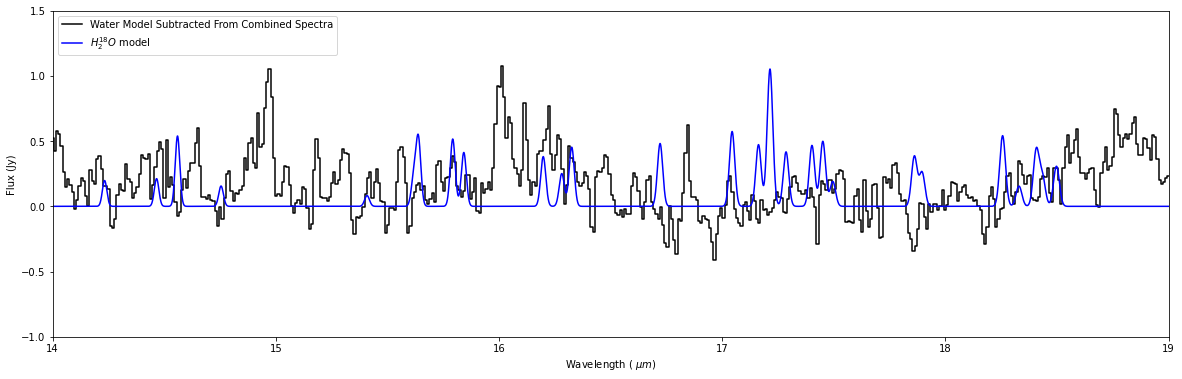

In [113]:
plt.figure(figsize = (20, 6))

plt.plot(xvals, subtracted, color='black', drawstyle='steps-mid', label='Water Model Subtracted From Combined Spectra')

xh218o = out_h218o['spectrum']['wave']
yh218o = out_h218o['spectrum']['convolflux'] / 320
plt.plot(xh218o,yh218o, color='b', label='$H_2^{18}O$ model')

plt.xlim(14, 19)
plt.ylim(-1, 1.5)

plt.xlabel('Wavelength ( $\mu m$)')
plt.ylabel('Flux (Jy)')
plt.legend(loc="upper left")


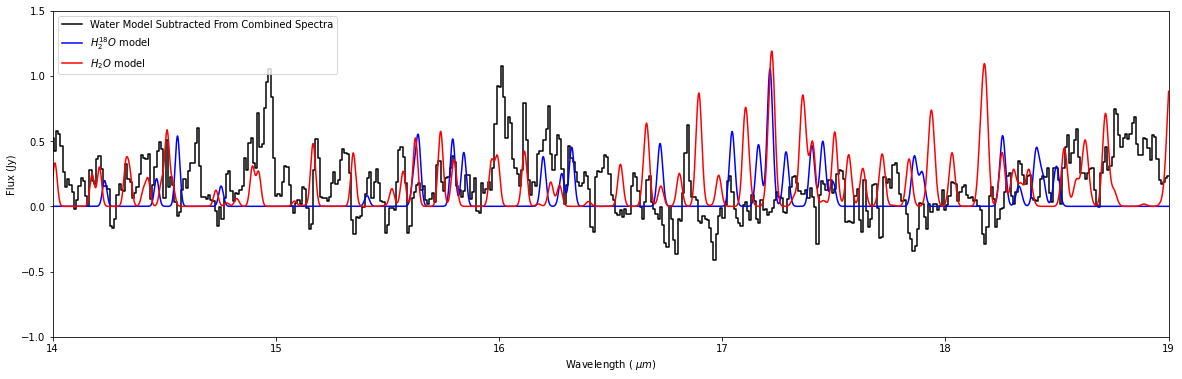

In [111]:
plt.figure(figsize = (20, 6))

plt.plot(xvals, subtracted, color='black', drawstyle='steps-mid', label='Water Model Subtracted From Combined Spectra')

xh218o = out_h218o['spectrum']['wave']
yh218o = out_h218o['spectrum']['convolflux'] / 320
plt.plot(xh218o,yh218o, color='b', label='$H_2^{18}O$ model')

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 305
plt.plot(xh2o,yh2o, color='r', label='$H_2O$ model')

plt.xlim(14, 19)
plt.ylim(-1, 1.5)

plt.xlabel('Wavelength ( $\mu m$)')
plt.ylabel('Flux (Jy)')
plt.legend(loc="upper left")